# Checkin

In [1]:
import pandas as pd
import numpy as np
import utils, plot_help
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
df = utils.chunk_loader(directory='data/checkin.json', c_size=10_000, read_limit=-1)

In [3]:
df.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [4]:
df.tail()

,business_id,date
161945,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
161946,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
161947,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
161948,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."
161949,zzzaIBwimxVej4tY6qFOUQ,"2012-10-12 16:26:35, 2012-10-19 19:31:14, 2012..."


In [5]:
#quick check if the leading -- is a typo
len(df[df['business_id'].str.contains('--')])

814

In [6]:
df.shape

(161950, 2)

In [7]:
df.dtypes

business_id    object
date           object
dtype: object

In [8]:
df.isna().mean()

business_id    0.0
date           0.0
dtype: float64

In [9]:
df.business_id.nunique()

161950

In [10]:
df['date'][1][:100]

'2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012-04-15 01:07:50, 2012-05-06 23:08:42, 2012-06-08 22:43'

#### To Do List

Each business has a list of checkins stored as strings associated to it. It makes more sense to transform the data into an event log where the time stamp is the index and the business ID is a feature:



| date | Business_id   |
|------|------|
|   2011-06-04 18:22:23  | 123aAdf|
|2011-07-23 23:51:33|--6MefnULPED_I942VcFNA|


## Event Log

In [11]:
#create dict that maps ID
bus_to_check = {}

for bus, dates in zip(df['business_id'], df['date']):
    dates_as_list = dates.split(',')
    bus_to_check[bus] = pd.to_datetime(dates_as_list)
    

In [12]:
#quick check
type(bus_to_check['--1UhMGODdWsrMastO9DZw'][0])

pandas._libs.tslibs.timestamps.Timestamp

Source for dict keys that point to list:
[http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/](http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/)

### Note: Python dictionaries must have unique keys, if the data is not granular enough then we will have duplicate keys and the fuction below will not work. 

In [13]:
check_to_bus = dict( (v,k) for k in bus_to_check for v in bus_to_check[k] )

### Alternatively we define a function that returns 2 congruent lists to sidestep this issue.

In [14]:
def make_event_lists (bus_to_date):
    """
    returns two congruent lists for a dict of lists
    bus_to_date(dict): a dictionary of lists
    """
    #list containers
    date_list = []
    key_list = []
    
    #iterate over each key
    for key in bus_to_date:
        #iterate over every item in list
        for event in bus_to_date[key]:
            #append in parallel everytime we come across a value
            key_list.append(key)
            date_list.append(event)
            
    return date_list, key_list

In [15]:
#create dataframe from dict
event_df = pd.DataFrame.from_dict(check_to_bus, orient='index', columns=['business_id'])
#sort by the index
event_df = event_df.sort_index(ascending=True)
event_df.head()

,business_id
2010-01-15 22:59:12,FaHADZARwnY4yvlvpnsfGA
2010-01-15 23:29:06,3KTY5XZfavc85u0_rLFHrw
2010-01-15 23:42:01,t-o_Sraneime4DDhWrQRBA
2010-01-16 00:54:25,Z2fCgJdvjhZVP34V86UKCg
2010-01-16 02:02:04,qwvpcuHVkOM8UoyfXmdIBA


In [31]:
#save the work
event_df.to_csv('data/cleaned/checkin_eventlog.csv')

## Count Events

In [16]:
#count number of checkins
event_df_count = event_df['business_id'].value_counts()

In [17]:
event_df_count.describe()

count    161160.000000
mean        111.764830
std         692.633997
min           1.000000
25%           4.000000
50%          16.000000
75%          61.000000
max      133247.000000
Name: business_id, dtype: float64

In [18]:
event_df_count.max()

133247

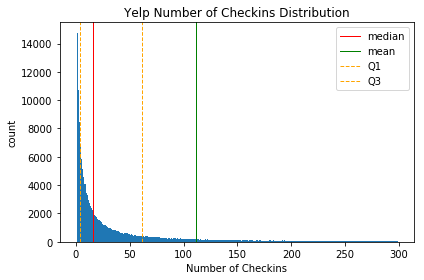

In [19]:
plot_help.plot_hist(event_df_count, end=300, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins',
                    saveloc='plots/checkin_count.png')

In [20]:
#get count of businesses with more than 1000 checkins
len(event_df_count[event_df_count.values>1000])

3072

We have business that are outliers and have so many checkins that they skew the data. We can make use of [Tukey's Method](https://www.stat.cmu.edu/~cshalizi/statcomp/13/labs/05/lab-05.pdf) to remove outliers. The convenince of the method is that it makes no assumptions about the distribution of the data

In [21]:
#calculate interquartile range
iqr = event_df_count.describe()['75%'] - event_df_count.describe()['25%']
iqr_min = event_df_count.describe()['25%'] - 1.5*iqr
iqr_max = event_df_count.describe()['75%'] + 1.5*iqr

print("IQR = {}".format(iqr))
print("Upper bound = {}".format(iqr_max))
print("Lower bound = {}".format(iqr_min))

IQR = 57.0
Upper bound = 146.5
Lower bound = -81.5


In [22]:
event_df_count_tuk = event_df_count[event_df_count.between(iqr_min, iqr_max)]

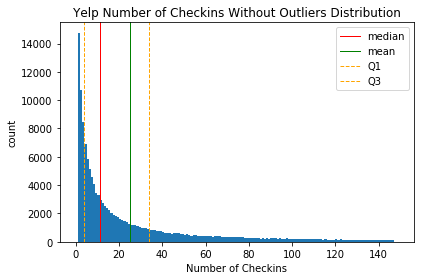

In [23]:
plot_help.plot_hist(event_df_count_tuk, end=150, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins Without Outliers',
                    saveloc='plots/checkin_count_tukey.png')

## Events Over Time

In [24]:
checkin_year = event_df.groupby(pd.Grouper(freq='Y')).count()
checkin_year

,business_id
2010-12-31,388202
2011-12-31,1550845
2012-12-31,2124681
2013-12-31,2506988
2014-12-31,2573504
2015-12-31,2595060
2016-12-31,2406357
2017-12-31,2179140
2018-12-31,1687243


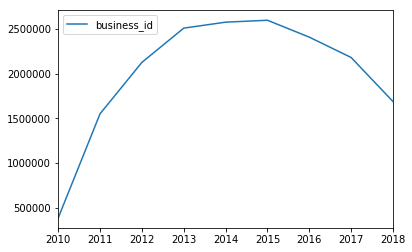

In [25]:
checkin_year.plot()

In [26]:
checkin_day = event_df.groupby(pd.Grouper(freq='1D')).count()
checkin_day.head()

,business_id
2010-01-15,3
2010-01-16,155
2010-01-17,161
2010-01-18,139
2010-01-19,102


In [40]:
mini_df = checkin_day[(checkin_day.index>'2010-01-01') & (checkin_day.index<'2011-01-01')]
mini_df.tail()

,business_id
2010-12-27,2340
2010-12-28,2525
2010-12-29,2577
2010-12-30,2700
2010-12-31,3180


In [27]:
def highlight(indices,ax):
    i=0
    while i<len(indices)-1:
        #to make sure we dont fill between a Sunday and the next Saturday
        if pd.Timedelta(indices[i+1]-indices[i]).total_seconds()/3600/24<1:
            ax.axvspan(indices[i], indices[i+1], facecolor='pink', edgecolor='none', alpha=.2, lw=100)
        i+=1

In [28]:
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

In [35]:
def highlight_weekend(weekend_indices,ax):
    i=0
    while i<len(weekend_indices):
        ax.axvspan(weekend_indices[i], weekend_indices[i]+2, facecolor='green', edgecolor='none', alpha=1)
        i+=2

In [36]:
weekend_indices = find_weekend_indices(checkin_day.index)

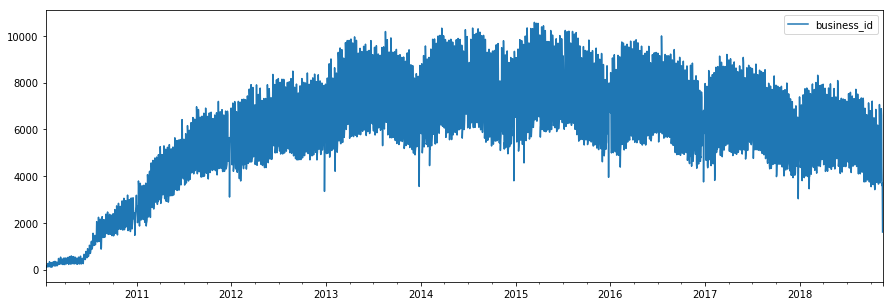

In [37]:
ax=checkin_day.plot(figsize=(15,5))
highlight_weekend(weekend_indices, ax)